# EFTofLSS Fisher forecasts on GC multipoles at z=0.5

In [1]:
# Name this run - this will determine the name for the file into which the covariance matrix will be saved
runname = 'el024_mcmcfids_EFT'

## Set up the notebook

In [2]:
# Import the science packages/libraries
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy, scipy.interpolate, scipy.misc, scipy.integrate, scipy.stats
import elgc
import getdist, getdist.plots, IPython
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import os.path as op
import matplotlib.pyplot as plt

In [3]:
# Set plotting and printing

%matplotlib inline

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

np.set_printoptions(precision=3,linewidth=200,suppress=False)

from matplotlib.patches import Ellipse

In [4]:
# Main question for the Fisher matrix calculation: which parameters are we varying?
# Note that this list determines the order in the output FM as well

#NB: the cs0, cs2, cs4 params here are actually the cs squared (like in the MCMC)
varypars = ['f','b','b2','N','cs0','cs2','cs4']

print(varypars)

['f', 'b', 'b2', 'N', 'cs0', 'cs2', 'cs4']


## Set up the fiducial model for the Fisher matrix calculation

In [5]:
#Fiducial (GR-COLA) cosmology 
#from cos.rtf file (changed some params names here)

zbin = 0.5

c=3e5
hubble = 0.697
H00 = 100*hubble
Tcmb = 2.726
ns = 0.971
om0 = 0.281
omb = 0.046
sigma80_fid = 0.844 #this is sigma8 at z=0

#Mean MCMC values for EFT at z=0.5 
fg_fid = 0.7042
b_fid = 1.468
b2_fid = -0.2756
N_fid = 816.1 
#NB: the cs0, cs2, cs4 params here are actually the cs squared (like in the MCMC)
cs0_fid = 7.650
cs2_fid = 2.978
cs4_fid = 24.40

#kmax at z=0.5 for multipoles: 0,2,4 
kmax = [0.245, 0.245,0.129]

In [6]:
#k values are the same in all files ### Paths to input files
PATHTOINPUTFILES = op.abspath('./inputs/')

# Function to read the output files from MG-COPTER
def read_copter(path,suffix=''):
    
    #naming files (following the Mathematica notebook)
    psfile = ('eft_ps_components_nw'+suffix+'.dat')
    abcfile = ('eft_abc_components'+suffix+'.dat')
    biasfile = ('eft_bias_components'+suffix+'.dat')
    
    # set the names of the columns (following the Mathematica notebook)
    pscolnames = 'k', 'pl', 'pdd', 'pdt', 'ptt', 'sv', 'plnw', 'pddres', 'pdtres', 'pttres','ANW'
    abccolnames = 'k', 'bu2f2nw', 'bu2f3nw', 'bu4f2nw', 'bu4f3nw', 'bu6f3nw', 'b2u2f1nw', 'b2u2f2nw', 'b2u2f3nw',\
    'b2u2f4nw', 'b2u4f2nw', 'b2u4f3nw', 'b2u4f4nw', 'b2u6f3nw', 'b2u6f4nw', 'b2u8f4nw', 'u2f4nw', 'u4f3nw', 'u4f4nw',\
    'u6f3nw', 'u6f4nw', 'u8f4nw' 
    biascolnames = 'k', 'ddb0b2nw', 'ddb02nw', 'ddb0nw', 'ddb22nw', 'ddb2nw', 'ddnonenw', 'dtb2nw', 'dtb0nw', 'dtnonenw'
    
    return np.genfromtxt(op.join(path,psfile), names=pscolnames),\
           np.genfromtxt(op.join(path,abcfile), names=abccolnames),\
           np.genfromtxt(op.join(path,biasfile), names=biascolnames)

# use numpy to read the whole files, the options will make the
# resulting object act a bit like a dictionary (a structured array)
# so we can query columns by name
ps_fid, abc_fid, bias_fid = read_copter(op.join(PATHTOINPUTFILES,'data_fid'),'_fid')
print ('ps column names:', ps_fid.dtype.names )# let's print the names to check
print ('abc column names:', abc_fid.dtype.names) # let's print the names to check
print ('bias column names:', bias_fid.dtype.names) # let's print the names to check

ps column names: ('k', 'pl', 'pdd', 'pdt', 'ptt', 'sv', 'plnw', 'pddres', 'pdtres', 'pttres', 'ANW')
abc column names: ('k', 'bu2f2nw', 'bu2f3nw', 'bu4f2nw', 'bu4f3nw', 'bu6f3nw', 'b2u2f1nw', 'b2u2f2nw', 'b2u2f3nw', 'b2u2f4nw', 'b2u4f2nw', 'b2u4f3nw', 'b2u4f4nw', 'b2u6f3nw', 'b2u6f4nw', 'b2u8f4nw', 'u2f4nw', 'u4f3nw', 'u4f4nw', 'u6f3nw', 'u6f4nw', 'u8f4nw')
bias column names: ('k', 'ddb0b2nw', 'ddb02nw', 'ddb0nw', 'ddb22nw', 'ddb2nw', 'ddnonenw', 'dtb2nw', 'dtb0nw', 'dtnonenw')


In [7]:
sv_fid = ps_fid['sv'][0] 
ANW = ps_fid['ANW'][0]

## Set up the survey properties

In [8]:
### Set up survey with volume 4 Gpc^3/h^3

Area = 15000.0*1.06 #deg^2 
Dzbin = 0.2
z_vals = np.array([zbin]) 
Nzbin = len(z_vals)

#set kmin 
kmin = 0.006

In [9]:
#construct array of mu values between -1 and 1 (inclusive)
mu_step = 0.005
mu = mu_step*np.arange((2/mu_step)+1)-1.
#print ('mu array', mu)
print (len(mu)) # Note that this has to be large enough to convert to multipoles!

# Select multipoles
MLPS = [0,2,4]

401


## Define cosmology functions: background and perturbations

In [10]:
# Functions for DE later
def w_integrand(z,w0=-1.,wa=0.):
    return (1 + w0+wa*z/(z+1)) / (1+z)
def DE_evo(zc,w0=-1.,wa=0.): 
    return np.exp(3*scipy.integrate.romberg(lambda z: w_integrand(z,w0,wa), 0, zc))

# Define E(z) = H(z)/H0
def Ez(zc,w0=-1.,wa=0.):
    return np.sqrt((1-om0)*DE_evo(zc,w0,wa) + om0*pow(1+zc,3))

# LCDM growth rate and growth factor
def fg(zz,w0=-1.,wa=0.,gamma=0.55):
    omz=om0*pow(1+zz,3)/pow(Ez(zz,w0,wa),2)
    return pow(omz,gamma)

def Dg_dz(zz,w0=-1.,wa=0.,gamma=0.55):
    return -fg(zz,w0,wa)/(1+zz)

def Dgz(zz,w0=-1.,wa=0.,gamma=0.55):
    start_z = 0.0
    ans = scipy.integrate.romberg(lambda z: Dg_dz(z,w0,wa), start_z, zz)
    return np.exp(ans)

nz = 100
fg_fid_interp = np.zeros(nz)
Dg_fid_interp = np.zeros(nz)
z_for_interp = np.linspace(0,2,nz)
for i,z in enumerate(z_for_interp):
    fg_fid_interp[i] = fg(z)
    Dg_fid_interp[i] = Dgz(z)

fg_fid_i = scipy.interpolate.interp1d(z_for_interp,fg_fid_interp,kind='cubic')
Dg_fid_i = scipy.interpolate.interp1d(z_for_interp,Dg_fid_interp,kind='cubic')
del z_for_interp, Dg_fid_interp, fg_fid_interp, i, z
print (fg_fid_i(zbin), Dg_fid_i(zbin))

0.733197112933542 0.7784487714884997


In [11]:
#Define E(z)=H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))

#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

def Vsur(zc): #  (the hubble**3 factor is for units consistency)
    z_min = zc-Dzbin/2
    DA_min = DA(z_min)
    z_max = zc+Dzbin/2
    DA_max = DA(z_max)
    
    F = (4.*np.pi/3.) / (4.*np.pi*(180./np.pi)**2)   
    return F * (DA_max**3 *(1+z_max)**3 - DA_min**3 *(1+z_min)**3) * hubble**3 * Area

print(round(Vsur(zbin)/1e9,3))

3.994


In [12]:
#construct the P_lin in 2d (i.e. in k-mu space) needed for the linear covariance used in the MCMC
def P_lin(mu_array,f,sig8_z=sigma80_fid*Dg_fid_i(zbin),ps=ps_fid):
    muones = mu_array**0.
    k_array = ps['k']
    
    D = sig8_z/sigma80_fid #every term that contains D, contains the same power of sigma80_fid
    
    blin = 1.46 
    
    res = blin**2*D**2*np.outer(ps['pl'],muones) + (f/blin)**2*blin**2*D**2*np.outer(ps['pl'],mu_array**4)\
    + 2.*(f/blin)*blin**2*D**2*np.outer(ps['pl'],mu_array**2)
                
    return res

In [13]:
#construct the P_EFT in 2d (i.e. in k-mu space)
def Peft_2d(mu_array,f,
         b=b_fid,b2=b2_fid,N=N_fid,
         cs0=cs0_fid,cs2=cs2_fid,cs4=cs4_fid,sv=sv_fid,
         sig8_z=sigma80_fid*Dg_fid_i(zbin),
         ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu_array**0.
    k_array = ps['k']
    
    D = sig8_z/sigma80_fid #every term that contains D, contains the same power of sigma80_fid
    
    #resummation part
    pddresum = D**2 * ps['plnw'] + D**4 * ps['pddres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * ps['pl'] + D**4 * ps['pdd'] - (D**2*ps['plnw'] + D**4*ps['pddres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(D**2*(ps['pl']-ps['plnw'])))
   
    pdtresum = D**2 * f * ps['plnw'] + D**4 * f * ps['pdtres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * f * ps['pl'] + D**4 * f * ps['pdt'] - (D**2*f*ps['plnw'] + D**4*f*ps['pdtres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(f*D**2*(ps['pl']-ps['plnw'])))
    
    pttresum = D**2 * f**2 * ps['plnw'] + D**4 * f**2 * ps['pttres']\
    + np.exp(-0.5*ps['k']**2*D**2*ANW) * ( D**2 * f**2 * ps['pl'] + D**4 * f**2 * ps['ptt'] - (D**2*f**2*ps['plnw'] + D**4*f**2*ps['pttres'])\
                                         +0.5*ps['k']**2*D**2*ANW*(f**2*D**2*(ps['pl']-ps['plnw'])))
    
    #total power spectrum
    FoG = (1 - f**2*np.outer(k_array**2,mu_array**2)*D**2*sv_fid)\
             
    res = FoG\
    *((b**2*np.outer(pddresum,muones)\
    + D**4*(b*b2*np.outer(bias['ddb0b2nw'],muones) + b**2*np.outer(bias['ddb02nw'],muones)\
    + b*np.outer(bias['ddb0nw'],muones) + b2**2*np.outer(bias['ddb22nw'],muones)\
    + b2*np.outer(bias['ddb2nw'],muones) + np.outer(bias['ddnonenw'],muones)) + N 
    + 2*(b*np.outer(pdtresum,mu_array**2))\
    - 2*D**4*f*(b2*np.outer(bias['dtb2nw'],mu_array**2) + b*np.outer(bias['dtb0nw'],mu_array**2) + np.outer(bias['dtnonenw'],mu_array**2)))\
    + np.outer(pttresum,mu_array**4))\
    + D**4*( b*f**2*np.outer(abc['bu2f2nw'],mu_array**2) + b*f**3*np.outer(abc['bu2f3nw'],mu_array**2)\
    + b*f**2*np.outer(abc['bu4f2nw'],mu_array**4)+b*f**3*np.outer(abc['bu4f3nw'],mu_array**4)\
    + b*f**3*np.outer(abc['bu6f3nw'],mu_array**6)+b**2*f*np.outer(abc['b2u2f1nw'],mu_array**2)\
    + b**2*f**2*np.outer(abc['b2u2f2nw'],mu_array**2)+b**2*f**3*np.outer(abc['b2u2f3nw'],mu_array**2)\
    + b**2*f**4*np.outer(abc['b2u2f4nw'],mu_array**2) + b**2*f**2*np.outer(abc['b2u4f2nw'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u4f3nw'],mu_array**4) + b**2*f**4*np.outer(abc['b2u4f4nw'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u6f3nw'],mu_array**6) + b**2*f**4*np.outer(abc['b2u6f4nw'],mu_array**6)\
    + b**2*f**4*np.outer(abc['b2u8f4nw'],mu_array**8) + f**4*np.outer(abc['u2f4nw'],mu_array**2)\
    + f**3*np.outer(abc['u4f3nw'],mu_array**4) + f**4*np.outer(abc['u4f4nw'],mu_array**4)\
    + f**3*np.outer(abc['u6f3nw'],mu_array**6) + f**4*np.outer(abc['u6f4nw'],mu_array**6)\
    + f**4*np.outer(abc['u8f4nw'],mu_array**8) )\
    - 2.*D**2*( np.outer(k_array**2*ps['plnw'],muones)*cs0 + np.outer(k_array**2*ps['plnw'],cs2*mu_array**2)\
    + np.outer(k_array**2*ps['plnw'],cs4*mu_array**4) + np.outer(k_array**2*ps['plnw'],muones)\
    *(f**3*cs0 - f**2*cs2 + f*cs4)*mu_array**6)
        
    return res

#print(Peft_2d(mu,fg_fid))

# Now convert to multipoles
def Peft(f,b=b_fid,b2=b2_fid,N=N_fid,
         cs0=cs0_fid,cs2=cs2_fid,cs4=cs4_fid,sv=sv_fid,
         sig8_z=sigma80_fid*Dg_fid_i(zbin),
         ps=ps_fid,abc=abc_fid,bias=bias_fid):
    
    pk2d = Peft_2d(mu,f,b,b2,N,cs0,cs2,cs4,sv,sig8_z,ps,abc,bias)
    
    return elgc.pkto1d(ps['k'],mu,pk2d,MLPS)

k_test, plk_test = Peft(fg_fid)
print (len(k_test),len(ps_fid['k']))
print ('k are preserved:',(elgc.get_k_once(k_test)==ps_fid['k']).all())
#plt.plot(k_test,plk_test,'.')
#plt.show()
#del k_test, plk_test

900 300
k are preserved: True


In [14]:
# Save the k-array nicely for later
k_once = ps_fid['k']
k_long = []
for l in MLPS:
    k_long = np.concatenate((k_long,k_once))

# Effective volume: basically Vsur*Cov^(-1)
nbar = 1e-3 #h^3/Mpc^3
def Veff(zc):
    n = nbar    
    Pkmu = P_lin(mu,fg_fid) #linear covariance 
    C = elgc.covll_reduced(k_once,mu,Pkmu,n,MLPS)
    return Vsur(zc) * np.linalg.inv(C)

veff = Veff(z_vals[0]) # save for later (we really only need to calculate this once per redshift)
print (veff.shape)

# This looks like it is twice the size of the 2d case 
# (but this is compensated for by an extra factor of 1/2 in the Fisher matrix)
print (veff) 

(900, 900)
[[1106.96     0.       0.    ...    0.       0.       0.   ]
 [   0.      27.222    0.    ...    0.       0.       0.   ]
 [   0.       0.       9.367 ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ...  104.19     0.       0.   ]
 [   0.       0.       0.    ...    0.     104.973    0.   ]
 [   0.       0.       0.    ...    0.       0.     105.765]]


## Define how to calculate the derivatives with respect to parameters we wish to vary

In [15]:
#Construct the derivatives wrt the bias and EFT parameters

#choose the step (convergent derivatives)
params_step = 1e-5

#Derivative wrt b
def dPeft_db():
    
    P_bp = Peft(fg_fid,b_fid*(1+params_step),b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_bm = Peft(fg_fid,b_fid*(1-params_step),b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_b = (P_bp - P_bm)/(2*b_fid*params_step)
    
    return deriv_b
    
    
#Derivative wrt b2
def dPeft_db2():
   
    P_b2p = Peft(fg_fid,b_fid,b2_fid*(1+params_step),N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    P_b2m = Peft(fg_fid,b_fid,b2_fid*(1-params_step),N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    
    deriv_b2 = (P_b2p - P_b2m)/(2*b2_fid*params_step)
    
    
    return deriv_b2

#Derivative wrt N
def dPeft_dN():
    P_Np = Peft(fg_fid,b_fid,b2_fid,N_fid*(1+params_step),
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_Nm = Peft(fg_fid,b_fid,b2_fid,N_fid*(1-params_step),
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_N = (P_Np - P_Nm)/(2*N_fid*params_step)
            
    return deriv_N

#Derivative wrt cs0 
def dPeft_dcs0(): 
    P_cs0p = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid*(1+params_step),cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_cs0m = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid*(1-params_step),cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_cs0 = (P_cs0p - P_cs0m)/(2*cs0_fid*params_step)
    
    return deriv_cs0

#Derivative wrt cs2
def dPeft_dcs2(): 
    P_cs2p = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid*(1+params_step),cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_cs2m = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid*(1-params_step),cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_cs2 = (P_cs2p - P_cs2m)/(2*cs2_fid*params_step)
    
    return deriv_cs2

#Derivative wrt cs4
def dPeft_dcs4(): 
    P_cs4p = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid*(1+params_step),sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_cs4m = Peft(fg_fid,b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid*(1-params_step),sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_cs4 = (P_cs4p - P_cs4m)/(2*cs4_fid*params_step)
    
    return deriv_cs4

#Derivative wrt f
def dPeft_df():
    P_fp = Peft(fg_fid*(1+params_step),b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_fm = Peft(fg_fid*(1-params_step),b_fid,b2_fid,N_fid,
                 cs0_fid,cs2_fid,cs4_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_f = (P_fp - P_fm)/(2*fg_fid*params_step)
    
    return deriv_f

## Set up the Fisher matrix calculation and run to loop to calculate its elements

In [16]:
k_step = k_once[6] - k_once[5] 

# k values range to include in the constraints calculation
k_index = np.zeros(len(k_long),dtype=int)
for il,l in enumerate(MLPS):
    k_index+= (k_long<kmax[il]) * elgc.get_l_boolindex(il,k_long)# kmax for monopole
k_index*= k_long>kmin   # And all have to be larger than minimum
k_index = k_index.astype(bool)

#print (k_index)
print (kmax)
print (len(k_long),'->',np.sum(k_index),'or',len(k_long[k_index]))

#plt.plot(k_long[k_index],plk_test[k_index],'.')
#plt.show()

[0.245, 0.245, 0.129]
900 -> 450 or 450


In [17]:
# This dictionary contains all the parameters that can be varied in this code.
derivs = {
    'b'  : lambda z: dPeft_db(),
    'b2' : lambda z: dPeft_db2(),
    'N'  : lambda z: dPeft_dN(),
    'cs0': lambda z: dPeft_dcs0(),
    'cs2': lambda z: dPeft_dcs2(),
    'cs4': lambda z: dPeft_dcs4(),
    'f'  : lambda z: dPeft_df()
}
            
# Which should depend on redshift
zdep = 'b','b2','N','cs0','cs2','cs4','f'

# Which ones are independent of redshift and should appear in the FM once (summ over z contributions)
zidep = [i for i in derivs.keys() if i not in zdep]
print (zidep)

[]


In [18]:
#print(dPeft_df())

In [19]:
# Auxiliary bits needed for Fisher matrix calculation

# Create array of zeros for the final FM
Nzdep = len(set(zdep)&set(varypars))
Npar = len(varypars)
s = Nzdep*Nzbin + (Npar-Nzdep)
Fishermat = np.zeros([s,s])

# Fisher matrix integrand - to be integrated over k and summed over l
# Do the whole sum together in one big matrix operation
def dF(zc,veff):
    di = deriv_i(zc)[k_index]*k_long[k_index]
    dj = deriv_j(zc)[k_index]*k_long[k_index]
    tmp = np.dot(di,veff[k_index,:][:,k_index])
    tmp = np.dot(tmp,dj)
    return tmp*k_step/(4*np.pi**2)

In [20]:
#%%time 
# We could optimize this still by precalculating the derivatives

# Save the indexing for posterity
fm_index = {'b' :[],'b2':[],'N' :[],'cs0':[],'cs2':[],'cs4':[],'f' :[]}

fm_head = []

# Loop over redshift bins
for iz, zc in enumerate(z_vals):
    
    veff = Veff(zc) # Let's not calculate this for every parameter - it stays the same at each redshift!
    
    # First loop over parameters (rows of the FM)
    for i, pi in enumerate(varypars): 
        
        # Calculate row index for the Fisher matrix
        if pi in zdep:
            zind = iz*Nzdep + i
        else:
            zind = Nzbin*Nzdep + (i-Nzdep)
                
        # Set the i derivative in dF to correspond to the row parameter
        def deriv_i(zc): return derivs[pi](zc)

        # Second loop over parameters (columns of the FM)
        for j, pj in enumerate(varypars):
            
            # Calculate column index for the Fisher matrix
            if pj in zdep:
                zjnd = iz*Nzdep + j
            else:
                zjnd = Nzbin*Nzdep + (j-Nzdep)
            
            # If not done yet, set the j derivative in dF to correspond to the column parameter
            if j>=i:
                
                def deriv_j(zc): return derivs[pj](zc)
                
                Fishermat[zind,zjnd] += dF(zc,veff)
            
            # Otherwise just take the symmetric value
            else: 
                Fishermat[zind,zjnd] = Fishermat[zjnd,zind]
        
        # Finally, save the index in the FM (same redshift order as z_vals)
        fm_index[pi].append(zind) # Only doing i, since it is symmetric
        
        # Save also the order of the colmns/rows
        headstr = pi
        if pi in zdep: headstr+='_'+str(zc)
        fm_head.append(headstr)

## Print out results

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
# Create a fiducial value dictionary
fids = {
    'b'  : b_fid*np.ones(Nzbin),   
    'b2' : b2_fid*np.ones(Nzbin),  
    'N'  : N_fid*np.ones(Nzbin),   
    'cs0': cs0_fid*np.ones(Nzbin), 
    'cs2': cs2_fid*np.ones(Nzbin), 
    'cs4': cs4_fid*np.ones(Nzbin), 
    'f'  : fg_fid*np.ones(Nzbin)
}

In [23]:
print ('Order of columns/rows:')
print (fm_head)
#print 'Fisher matrix:\n',
#print Fishermat

# Invert the Fisher matrix to get the parameter covariance
CovMat = np.linalg.inv(Fishermat)
print ('\nCorrelation matrix for parameters:\n', )
print (CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))

print ('\nCorrelation matrix diagonal:\n', )
print( np.diag(CovMat))

Order of columns/rows:
['f_0.5', 'b_0.5', 'b2_0.5', 'N_0.5', 'cs0_0.5', 'cs2_0.5', 'cs4_0.5']

Correlation matrix for parameters:

[[ 1.    -0.451 -0.506  0.344 -0.567  0.131  0.211]
 [-0.451  1.     0.967 -0.987 -0.253  0.412  0.391]
 [-0.506  0.967  1.    -0.965 -0.082  0.383  0.287]
 [ 0.344 -0.987 -0.965  1.     0.329 -0.456 -0.426]
 [-0.567 -0.253 -0.082  0.329  1.    -0.564 -0.401]
 [ 0.131  0.412  0.383 -0.456 -0.564  1.    -0.328]
 [ 0.211  0.391  0.287 -0.426 -0.401 -0.328  1.   ]]

Correlation matrix diagonal:

[5.741e-04 1.147e-03 4.537e-01 1.075e+06 6.652e+00 3.441e+01 8.465e+00]


In [24]:
# Print the errors nicely
Nvar  = len(varypars)

varyshape = list(set(zidep)&set(varypars))
if len(varyshape)>0:
    shapeind = [fm_index[p][0] for p in varyshape]
    shapefid = np.array([fids[p] for p in varyshape])
    print ('\nvarying shape = \n\t', varyshape)
    print ('shape fiducials = \n\t', shapefid)
    print ('unmarged err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind])
    print ('marged err = \n\t', np.sqrt(np.diag(CovMat))[shapeind])
    print ('unmarged % err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind]/np.abs(shapefid)*100)
    print ('marged % err = \n\t', np.sqrt(np.diag(CovMat))[shapeind]/np.abs(shapefid)*100)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['f', 'b', 'b2', 'N', 'cs0', 'cs2', 'cs4']
at z = 0.5 : zdep fiducials = 
	 [ 7.042e-01  1.468e+00 -2.756e-01  8.161e+02  7.650e+00  2.978e+00  2.440e+01]
at z = 0.5 : marged err = 
	 [2.396e-02 3.387e-02 6.736e-01 1.037e+03 2.579e+00 5.866e+00 2.909e+00]
at z = 0.5 : unmarged err = 
	 [2.771e-03 1.092e-03 5.724e-03 7.241e+00 6.360e-02 2.516e-01 1.689e-01]
at z = 0.5 : marged % err = 
	 [  3.403   2.307 244.396 127.016  33.713 196.991  11.924]
at z = 0.5 : unmarged % err = 
	 [0.394 0.074 2.077 0.887 0.831 8.447 0.692]


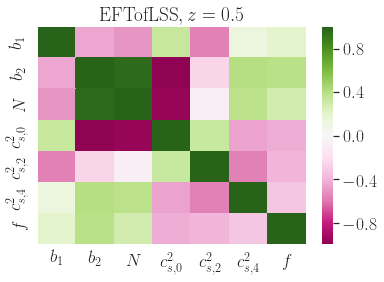

In [25]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(6,4))
df = pd.DataFrame(CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))
df.rename(columns={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
df.rename(index={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1)

ax.set_title('$\mathrm{EFTofLSS}, z=0.5$')
#plt.savefig('corr-mat-eft-zeq0p5.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [26]:
df

,$b_1$,$b_2$,$N$,"$c^2_{s,0}$","$c^2_{s,2}$","$c^2_{s,4}$",$f$
$b_1$,1.000000,-0.451485,-0.506048,0.343678,-0.566955,0.130634,0.210926
$b_2$,-0.451485,1.000000,0.967421,-0.986652,-0.253217,0.411791,0.391436
$N$,-0.506048,0.967421,1.000000,-0.965306,-0.081515,0.383110,0.286686
"$c^2_{s,0}$",0.343678,-0.986652,-0.965306,1.000000,0.329496,-0.455758,-0.425693
"$c^2_{s,2}$",-0.566955,-0.253217,-0.081515,0.329496,1.000000,-0.563878,-0.401088
"$c^2_{s,4}$",0.130634,0.411791,0.383110,-0.455758,-0.563878,1.000000,-0.327548
$f$,0.210926,0.391436,0.286686,-0.425693,-0.401088,-0.327548,1.000000


## Add Gaussian priors on parameters.

In [27]:
EFTmat = Fishermat*0.
EFT_errors = {
    #'b': (b_fid/100)*10,
    'b2': abs(b2_fid/100)*70,
    #'N': (N_fid/100)*10,
    'cs0': (cs0_fid/100)*70,
    'cs4': (cs2_fid/100)*70,
    'cs2': (cs2_fid/100)*70
}
for p in EFT_errors.keys():
    if p not in varyzdep: continue
    print (p, 'index', fm_index[p][0])
    EFTmat[fm_index[p][0],fm_index[p][0]] = 1./EFT_errors[p]**2

priorfactor = 1.0 #=0.0 if no priors   
    
Fishermat = Fishermat+priorfactor*EFTmat
CovMat = scipy.linalg.pinv(Fishermat)
print ('combined marged',  np.sqrt(np.diag(CovMat)))

print ('\nCorrelation coefficients after adding EFT parameters priors:')
print (CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))

b2 index 2
cs0 index 4
cs4 index 6
cs2 index 5
combined marged [1.650e-02 1.111e-02 1.831e-01 3.034e+02 1.572e+00 1.909e+00 1.565e+00]

Correlation coefficients after adding EFT parameters priors:
[[ 1.    -0.383 -0.318  0.078 -0.444  0.251  0.501]
 [-0.383  1.     0.753 -0.891 -0.285  0.139  0.365]
 [-0.318  0.753  1.    -0.809  0.145  0.065  0.106]
 [ 0.078 -0.891 -0.809  1.     0.452 -0.235 -0.542]
 [-0.444 -0.285  0.145  0.452  1.    -0.437 -0.699]
 [ 0.251  0.139  0.065 -0.235 -0.437  1.    -0.157]
 [ 0.501  0.365  0.106 -0.542 -0.699 -0.157  1.   ]]


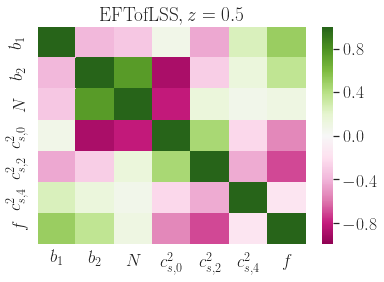

In [28]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(6,4))
df = pd.DataFrame(CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))
df.rename(columns={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
df.rename(index={0:'$b_1$',1:'$b_2$',2:'$N$',3:'$c^2_{s,0}$',4:'$c^2_{s,2}$',5:'$c^2_{s,4}$',6:'$f$',7:'$\sigma_8$',8:'$D_A$',9:'$H$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1)

ax.set_title('$\mathrm{EFTofLSS}, z=0.5$')
#plt.savefig('corr-mat-eft.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [29]:
df

,$b_1$,$b_2$,$N$,"$c^2_{s,0}$","$c^2_{s,2}$","$c^2_{s,4}$",$f$
$b_1$,1.000000,-0.383421,-0.317657,0.077592,-0.443676,0.251401,0.501286
$b_2$,-0.383421,1.000000,0.752971,-0.890965,-0.284757,0.138569,0.364981
$N$,-0.317657,0.752971,1.000000,-0.808628,0.144903,0.064791,0.105794
"$c^2_{s,0}$",0.077592,-0.890965,-0.808628,1.000000,0.451515,-0.234582,-0.541537
"$c^2_{s,2}$",-0.443676,-0.284757,0.144903,0.451515,1.000000,-0.437358,-0.698726
"$c^2_{s,4}$",0.251401,0.138569,0.064791,-0.234582,-0.437358,1.000000,-0.156943
$f$,0.501286,0.364981,0.105794,-0.541537,-0.698726,-0.156943,1.000000


In [30]:
# Print the errors nicely
Nvar  = len(varypars)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['f', 'b', 'b2', 'N', 'cs0', 'cs2', 'cs4']
at z = 0.5 : zdep fiducials = 
	 [ 7.042e-01  1.468e+00 -2.756e-01  8.161e+02  7.650e+00  2.978e+00  2.440e+01]
at z = 0.5 : marged err = 
	 [1.650e-02 1.111e-02 1.831e-01 3.034e+02 1.572e+00 1.909e+00 1.565e+00]
at z = 0.5 : unmarged err = 
	 [2.771e-03 1.092e-03 5.722e-03 7.241e+00 6.359e-02 2.498e-01 1.684e-01]
at z = 0.5 : marged % err = 
	 [ 2.343  0.757 66.428 37.172 20.546 64.098  6.415]
at z = 0.5 : unmarged % err = 
	 [0.394 0.074 2.076 0.887 0.831 8.387 0.69 ]


##### Alkistis & Dida, 2019